####CENTROID DATA TO GET AXES SUBSET

In [5]:
category = "Nature"

In [6]:
DIR = "/Users/damoncrockett/Desktop/cities_20k/yahoo/NEW_Clusters/Clusters_Normalized/"

In [7]:
DATA = DIR+"Normalized_Clustered/50/cluster_characterization_"+category+".csv"

In [8]:
import pandas as pd
centroids = pd.read_csv(DATA)
del centroids['Unnamed: 0']

####CATEGORY DATA TO GET IMAGE SUBSET

In [9]:
DATA = DIR+"Normalized_Cluster_Labels/50/"+category+".csv"

In [10]:
images = pd.read_csv(DATA)

####ADD LOCAL PATHS TO FULL METADATA

In [11]:
BASE = "/Users/damoncrockett/Desktop/cities_20k/"

In [12]:
import glob
import os

In [13]:
for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    tmp = pd.read_csv(file)
    n = len(tmp.index)
    local_path = []
    for i in range(n):
        local_path.append(BASE+os.path.basename(file).split("_")[0]+"_20k/"+tmp.ad_id.loc[i]+".jpg")
    tmp['local_path'] = local_path
    tmp.to_csv(file,index=False)

####SUBSET FULL DATA BY AXES AND IMAGES

In [14]:
counter=-1

for file in glob.glob(os.path.join(BASE+"yahoo/","*.tsv")):
    counter+=1
    tmp = pd.read_csv(file)
    columns = list(centroids.columns.values)
    columns.append("local_path")
    tmp = tmp[columns]
    if counter==0:
        collection = tmp
    else:
        collection = collection.append(tmp)

In [15]:
image_subset = list(set(list(images.local_path)))
collection = collection[collection.local_path.isin(image_subset)]

In [16]:
collection.reset_index(drop=True,inplace=True)

In [17]:
num_cols = len(collection.columns)

####PROJECTION TO 2D

In [18]:
from sklearn.decomposition import RandomizedPCA as pca
from sklearn.manifold import TSNE as tsne

#pca = pca(n_components=2)
tsne = tsne(n_components=2)

X = collection.iloc[:,0:num_cols-1].as_matrix()

#pca.fit(X)
tsne.fit(X)

In [19]:
#subspace_pca = pd.DataFrame(pca.transform(X),columns=["x","y"])
subspace_tsne = pd.DataFrame(tsne.fit_transform(X),columns=["x","y"])

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
#x = subspace_pca.x
#y = subspace_pca.y
#fig, ax = plt.subplots(figsize=(4,4))
#ax.scatter(x, y)

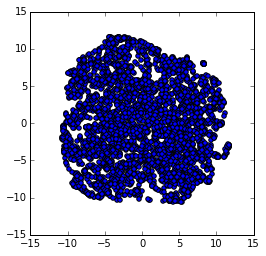

In [22]:
x = subspace_tsne.x
y = subspace_tsne.y
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(x, y)

####BIN

In [73]:
num_bins = 16

In [74]:
subspace_tsne['grid_x'] = pd.cut(subspace_tsne['x'],num_bins,labels=False)
subspace_tsne['grid_y'] = pd.cut(subspace_tsne['y'],num_bins,labels=False)

####ADD PATHS

In [76]:
subspace_tsne['local_path'] = collection.local_path

####PLOT

In [77]:
n = len(subspace_tsne.index)

In [78]:
from PIL import Image

In [79]:
thumb_side = 64

In [80]:
grid_side = num_bins

In [81]:
px_w = thumb_side * grid_side
px_h = thumb_side * grid_side

In [82]:
canvas = Image.new('RGB',(px_w,px_h),(50,50,50))

In [83]:
for i in range(n):
    im = Image.open(subspace_tsne.local_path.loc[i])
    im.thumbnail((thumb_side,thumb_side),Image.ANTIALIAS)
    x = subspace_tsne.grid_x.loc[i] * thumb_side
    y = subspace_tsne.grid_y.loc[i] * thumb_side
    canvas.paste(im,(x,y))

In [84]:
canvas.save("/Users/damoncrockett/Desktop/gridsnap_stack/Nature_tsne_"+str(num_bins)+".png")